## RL for PdM - PhD Thesis work
- V.2.0 13-Aug-2024: Two environments - similar rewards.

**Approach**
- Create two environments: PHM and NUAA
- To demonstrate robustness - Use multiple data sets from each 3 + 3 = 6
- Additional: Add noise and Break-down
- Publish results

**Implementation Notes**
- Issue was RUL threshold should have some value and not 0

In [25]:
import warnings
from tqdm import tqdm # Progress bar
from datetime import datetime
warnings.filterwarnings('ignore')

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# RL libraries
import gymnasium as gym
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, A2C
from stable_baselines3.ppo import MlpPolicy
from torch.utils.tensorboard import SummaryWriter

# Custom libraries
from MT_environment import MillingTool_Env_PHM,  MillingTool_Env_NUAA 
from utilities import downsample, tool_wear_data

now = datetime.now()
dt_string = now.strftime("%d-%b-%Y  %H:%M:%S")

In [26]:
# NUAA_W1_0p229.csv, NUAA_W3_0p12.csv,  NUAA_W8_0p281.csv
# PHM_C01_0p12.csv,  PHM_C04_0p098.csv, PHM_C06_0p13.csv

In [27]:
ENV_TYPE = 'PHM'

if ENV_TYPE == 'NUAA':
    DATA_FILE = 'NUAA_W8_0p281.csv'
    WEAR_THRESHOLD = 0.229
else:
    DATA_FILE = 'PHM_C06_0p13.csv'
    WEAR_THRESHOLD = 0.13

SAMPLING_RATE = 1
ADD_NOISE = 0

ALGO = 'A2C'
EPISODES = 8_000
BATCH_SIZE = 16
EVALUATION_ROUNDS = 20
TENSOR_BOARD = False

PRETRAINED_MODEL = True # If True load model. If False save as model_file 
PATH = 'D:/ResearchLab/IRL/IRL_for_PdM'
DATA_PATH = f'{PATH}/Data/Training_datasets'
DATA_FILE = f'{DATA_PATH}/{DATA_FILE}'
# MODEL_FILE = f'{PATH}/models/Agent_{ENV_TYPE}_{ALGO}'
MODEL_FILE = f'{PATH}/models/PdM_Agent'
# LOG_PATH = f'{PATH}/tensorboard/'
LOG_PATH = f'{PATH}/tensorboard/{ENV_TYPE}/'

writer = SummaryWriter(LOG_PATH) if TENSOR_BOARD else None 
print(f'Data set: {DATA_FILE}')
print(f'Tensorboard logging to {LOG_PATH}')

Data set: D:/ResearchLab/IRL/IRL_for_PdM/Data/Training_datasets/PHM_C06_0p13.csv
Tensorboard logging to D:/ResearchLab/IRL/IRL_for_PdM/tensorboard/PHM/


- Down-sampling. Input data records: 1020. Sampling rate: 1. Expected rows 1020.    Down-sampled to 1020 rows.


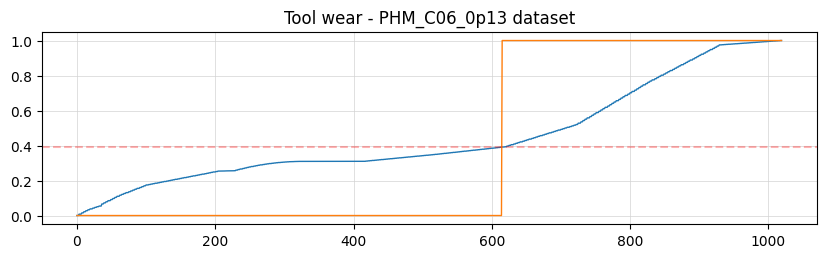

Tool failure RUL threshold at time 969 is 0.014


In [28]:
tool_wear, action_code, WEAR_THRESHOLD_NORMALIZED, df_train = tool_wear_data(
    env_type = ENV_TYPE, data_file=DATA_FILE, wear_threshold = WEAR_THRESHOLD,
    normalize=True, add_noise=ADD_NOISE, sampling_rate = SAMPLING_RATE)

records = len(df_train.index)
MILLING_OPERATIONS_MAX = records

rul_threshold_record = int(0.95 * records)
rul_threshold = df_train.loc[df_train.index[rul_threshold_record], 'RUL']
print(f'Tool failure RUL threshold at time {rul_threshold_record} is {rul_threshold:3.3f}')

## 1. Predictive maintenance environment

In [29]:
from stable_baselines3.common.env_checker import check_env

gym.register(
    id = 'custom/MillingToolEnv-v0',
    entry_point = MillingTool_Env_NUAA if ENV_TYPE == 'NUAA' else MillingTool_Env_PHM,
    max_episode_steps = MILLING_OPERATIONS_MAX,)

mt_env = gym.make('custom/MillingToolEnv-v0', records=records, rul_threshold=rul_threshold)
# Check env. formation 
check_env(mt_env)


 --  Milling tool environment initiatlized. Potential records 1020. RUL threshold 0.014


In [30]:
mt_env.tool_wear_data(df_train)


 - Milling tool environment: Tool wear data updated: 1020


## 2. Train the PdM Agent

In [31]:
if ALGO == 'PPO':
    if TENSOR_BOARD:
        expert_ppo = PPO('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
    else:
        expert_ppo = PPO('MlpPolicy', env=mt_env)
    
    if not PRETRAINED_MODEL:
        print(f'- Training a *NEW* {ALGO} Expert model...')
        expert_ppo.learn(EPISODES)
        print(f'- Saving Expert model in {MODEL_FILE}')
        expert_ppo.save(MODEL_FILE)
    else:
        print(f'- Loading pre-tranined {ALGO} Expert model from {MODEL_FILE}')
        expert_ppo = PPO.load(MODEL_FILE)
elif ALGO == 'A2C':
    if TENSOR_BOARD:
        expert_a2c = A2C('MlpPolicy', env=mt_env, tensorboard_log=LOG_PATH)
    else:
        expert_a2c = A2C('MlpPolicy', env=mt_env)
    
    if not PRETRAINED_MODEL:
        print(f'- Training a *NEW* {ALGO} Expert model...')
        expert_a2c.learn(EPISODES)
        print(f'- Saving Expert model in {MODEL_FILE}')
        expert_a2c.save(MODEL_FILE)
    else:
        print(f'- Loading pre-tranined {ALGO} Expert model from {MODEL_FILE}')
        expert_a2c = A2C.load(MODEL_FILE)

- Loading pre-tranined A2C Expert model from D:/ResearchLab/IRL/IRL_for_PdM/models/PdM_Agent


In [44]:
print('-'*120)
print(' **** Reinforcement Learning for Predictive Maintenance ****')
print('-'*120)

print(dt_string)
print(f'Algo. {ALGO} - Episodes:  {EPISODES}')

if ALGO == 'PPO':
    reward_ppo, _ = evaluate_policy(expert_ppo, mt_env, EVALUATION_ROUNDS)
    print(f'PPO agent: {reward_ppo:5.2f}')
elif ALGO == 'A2C':
    reward_a2c, _ = evaluate_policy(expert_a2c, mt_env, EVALUATION_ROUNDS)
    print(f'A2C agent: {reward_a2c:5.2f}')

------------------------------------------------------------------------------------------------------------------------
 **** Reinforcement Learning for Predictive Maintenance ****
------------------------------------------------------------------------------------------------------------------------
15-Oct-2024
Algo. A2C - Episodes:  8000
A2C agent: 4361.83


In [45]:
now = datetime.now()
dt_string = now.strftime('%d-%b-%Y')

In [46]:
import csv
from pathlib import Path

data_file_name = (DATA_FILE.split('/')[-1])

results=[now.strftime('%d-%b-%Y'), now.strftime('%H:%M:%S'), ALGO, ENV_TYPE, data_file_name, EVALUATION_ROUNDS, round(reward_a2c, 3)]
print(results)

# Check if reports file exists 
report_file = Path('Report.csv')
if not report_file.is_file():
    print('New report file created.')
    report_columns=['Date', 'Time', 'Algo', 'Data-set', 'Data file', 'Evaluation rounds', 'Rewards']
    with open(report_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(report_columns)
else:
    print('Results added to report file.')
    with open(report_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(results)

['15-Oct-2024', '20:00:02', 'A2C', 'PHM', 'PHM_C06_0p13.csv', 20, 4361.825]
Results added to report file.
